(intro_concepts)=
# Introductory Concepts

FLORIS is a Python-based software library for calculating wind farm performance considering
the effect of turbine-turbine interactions through their wakes.
There are two primary packages to understand when using FLORIS:
- `floris.core`: This package contains the core functionality for calculating the wind farm wake
    and turbine-turbine interactions. This package is the computational engine of FLORIS.
    All of the mathematical models and algorithms are implemented here.
- `floris`: This is the top-level package that provides most of the functionality that the
    majority of users will need. The main entry point is `FlorisModel` which is a high-level
    interface to the computational engine.

<!-- TODO add chart  -->

Users of FLORIS will develop a Python script with the following sequence of steps:

1. Load inputs and preprocess data
2. Run the wind farm wake calculation
3. Extract data and postprocess results

Generally, users will only interact with `floris` and most often through the `FlorisModel` class.
Additionally, `floris` contains functionality for comparing results, creating visualizations,
and developing optimization cases. 

This notebook steps through the basic ideas and operations of FLORIS while showing
realistic uses and expected behavior.

## Initialize Floris

The `FlorisModel` class provides functionality to build a wind farm representation and drive
the simulation. This object is created (instantiated) by passing the path to a FLORIS input
file as the only argument. After this object is created, it can immediately be used to
inspect the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from floris import FlorisModel

fmodel = FlorisModel("gch.yaml")
x, y = fmodel.get_turbine_layout()

print("     x       y")
for _x, _y in zip(x, y):
    print(f"{_x:6.1f}, {_y:6.1f}")

     x       y
   0.0,    0.0
 630.0,    0.0
1260.0,    0.0


## Build the model

At this point, FLORIS has been initialized with the data defined in the input file.
However, it is often simplest to define a basic configuration in the input file as
a starting point and then make modifications in the Python script. This allows for
generating data algorithmically or loading data from a data file. Modifications to
the wind farm representation are handled through the `FlorisModel.set()`
function with keyword arguments. Another way to think of this function is that it
changes the value of inputs specified in the input file.

Let's change the location of turbines in the wind farm. The code below changes the
initial 3x1 layout to a 2x2 rectangular layout.

In [2]:
x_2x2 = [0, 0, 800, 800]
y_2x2 = [0, 400, 0, 400]
fmodel.set(layout_x=x_2x2, layout_y=y_2x2)

x, y = fmodel.get_turbine_layout()

print("     x       y")
for _x, _y in zip(x, y):
    print(f"{_x:6.1f}, {_y:6.1f}")

     x       y
   0.0,    0.0
   0.0,  400.0
 800.0,    0.0
 800.0,  400.0


Additionally, we can change the wind speeds, wind directions, and turbulence intensity.
The set of wind conditions is given as arrays of wind speeds, wind directions, and turbulence
intensity combinations that describe the atmospheric conditions to compute.
This requires that all arrays be the same length.

Notice that we can give `FlorisModel.set()` multiple keyword arguments at once.
There is no expected output from the `FlorisModel.set()` function.

In [3]:
fmodel.set(wind_directions=[270.0], wind_speeds=[8.0], turbulence_intensities=[0.1])

fmodel.set(
    wind_directions=[270.0, 280.0],
    wind_speeds=[8.0, 8.0],
    turbulence_intensities=[0.1, 0.1],
)

fmodel.set(
    wind_directions=[270.0, 280.0, 270.0, 280.0],
    wind_speeds=[8.0, 8.0, 9.0, 9.0],
    turbulence_intensities=[0.1, 0.1, 0.1, 0.1],
)

`FlorisModel.set()` creates all of the basic data structures required
for the simulation but it does not do any aerodynamic calculations. The low level
data structures have a complex shape that enables faster computations. Specifically,
most data is structured as a 4-dimensional Numpy array with the following dimensions:

```python
np.array(
    (
        findex,
        turbines,
        grid-1,
        grid-2
    )
)
```

The `findex` dimension contains the index to a particular calculation in the overall data
domain. This typically represents a unique combination of wind direction and wind speed
making up a wind condition, but it can also be used to represent any other varying quantity.

For example, we can see the shape of the data structure for the grid point x-coordinates
for the all turbines and get the x-coordinates of grid points for the third turbine in
the first wind condition. We can also plot all the grid points in
space to get an idea of the overall form of our grid.

Dimensions of grid x-components
(4, 4, 3, 3)

3rd turbine x-components for first wind condition (at findex=0)
[[800. 800. 800.]
 [800. 800. 800.]
 [800. 800. 800.]]


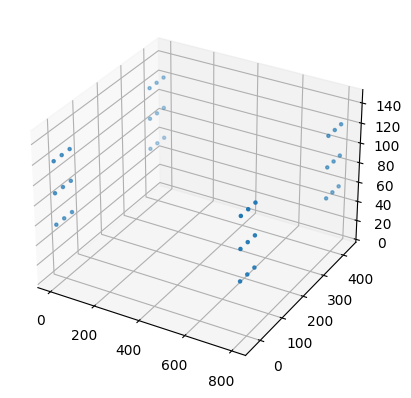

In [4]:
print("Dimensions of grid x-components")
print(np.shape(fmodel.core.grid.x_sorted))

print()
print("3rd turbine x-components for first wind condition (at findex=0)")
print(fmodel.core.grid.x_sorted[0, 2, :, :])

x = fmodel.core.grid.x_sorted[0, :, :, :]
y = fmodel.core.grid.y_sorted[0, :, :, :]
z = fmodel.core.grid.z_sorted[0, :, :, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, marker=".")
ax.set_zlim([0, 150])
plt.show()

## Run the Floris wake calculation

Running the wake calculation is a one-liner. This will calculate the velocities
at each turbine given the wake of other turbines for every wind speed and wind
direction combination. Since we have not explicitly specified yaw control settings
when creating the `FlorisModel` settings, all turbines are aligned with the inflow.

In [5]:
fmodel.run()

## Get turbine power

At this point, the simulation has completed and we can use `FlorisModel` to
extract useful information such as the power produced at each turbine. Remember that
we have configured the simulation with four wind conditions and four turbines.

In [6]:
powers = fmodel.get_turbine_powers() / 1000.0  # calculated in Watts, so convert to kW

print("Dimensions of `powers`")
print( np.shape(powers) )

N_TURBINES = fmodel.core.farm.n_turbines

print()
print("Turbine powers for 8 m/s")
for i in range(2):
    print(f"Wind condition {i}")
    for j in range(N_TURBINES):
        print(f"  Turbine {j} - {powers[i, j]:7,.2f} kW")
    print()

print("Turbine powers for all turbines at all wind conditions")
print(powers)

Dimensions of `powers`
(4, 4)

Turbine powers for 8 m/s
Wind condition 0
  Turbine 0 - 1,753.95 kW
  Turbine 1 - 1,753.95 kW
  Turbine 2 -  904.68 kW
  Turbine 3 -  904.85 kW

Wind condition 1
  Turbine 0 - 1,753.95 kW
  Turbine 1 - 1,753.95 kW
  Turbine 2 - 1,644.86 kW
  Turbine 3 - 1,643.39 kW

Turbine powers for all turbines at all wind conditions
[[1753.95445918 1753.95445918  904.68478734  904.84672946]
 [1753.95445918 1753.95445918 1644.85720431 1643.39012544]
 [2496.42786184 2496.42786184 1276.4580679  1276.67310219]
 [2496.42786184 2496.42786184 2354.40522998 2352.47398836]]


## Applying yaw angles

Yaw angles are another configuration option through `FlorisModel.set`.
In order to fit into the vectorized framework, the yaw settings must be represented as
a `Numpy.array` with  dimensions equal to:
- 0: findex
- 1: number of turbines

It is typically easiest to start with an array of 0's and modify individual
turbine yaw settings, as shown below.

In [7]:
# Recall that the previous `fmodel.set()` command set up four atmospheric conditions
# and there are 4 turbines in the farm.  So, the yaw angles array must be 4x4.
yaw_angles = np.zeros((4, 4))
print("Yaw angle array initialized with 0's")
print(yaw_angles)

print("First turbine yawed 25 degrees for every atmospheric condition")
yaw_angles[:, 0] = 25
print(yaw_angles)

fmodel.set(yaw_angles=yaw_angles)

Yaw angle array initialized with 0's
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
First turbine yawed 25 degrees for every atmospheric condition
[[25.  0.  0.  0.]
 [25.  0.  0.  0.]
 [25.  0.  0.  0.]
 [25.  0.  0.  0.]]


## Start to finish

Let's put it all together. The code below outlines these steps:
1. Load an input file
2. Modify the inputs with a more complex wind turbine layout and additional atmospheric conditions
3. Calculate the velocities at each turbine for all atmospheric conditions
4. Get the total farm power
5. Develop the yaw control settings
6. Calculate the velocities at each turbine for all atmospheric conditions with the new yaw settings
7. Get the total farm power
8. Compare farm power with and without wake steering

In [8]:
# 1. Load an input file
fmodel = FlorisModel("gch.yaml")

# 2. Modify the inputs with a more complex wind turbine layout
D = 126.0  # Design the layout based on turbine diameter
x = [0, 0,  6 * D, 6 * D]
y = [0, 3 * D, 0, 3 * D]
wind_directions = [270.0, 280.0]
wind_speeds = [8.0, 8.0]
turbulence_intensities = [0.1, 0.1]

# Pass the new data to FlorisInterface
fmodel.set(
    layout_x=x,
    layout_y=y,
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    turbulence_intensities=turbulence_intensities,
)

# 3. Calculate the velocities at each turbine for all atmospheric conditions
# All turbines have 0 degrees yaw
fmodel.run()

# 4. Get the total farm power
turbine_powers = fmodel.get_turbine_powers() / 1000.0  # Given in W, so convert to kW
farm_power_baseline = np.sum(turbine_powers, 1)  # Sum over the second dimension

# 5. Develop the yaw control settings
yaw_angles = np.zeros( (2, 4) )    # Construct the yaw array with dimensions for two wind directions, one wind speed, and four turbines
yaw_angles[0, 0] = 25           # At 270 degrees, yaw the first turbine 25 degrees
yaw_angles[0, 1] = 15           # At 270 degrees, yaw the second turbine 15 degrees
yaw_angles[1, 0] = 10           # At 280 degrees, yaw the first turbine 10 degrees
yaw_angles[1, 1] = 0            # At 280 degrees, yaw the second turbine 0 degrees
fmodel.set(yaw_angles=yaw_angles)

# 6. Calculate the velocities at each turbine for all atmospheric conditions with the new yaw settings
fmodel.run()

# 7. Get the total farm power
turbine_powers = fmodel.get_turbine_powers() / 1000.0
farm_power_yaw = np.sum(turbine_powers, 1)

# 8. Compare farm power with and without wake steering
difference = 100 * (farm_power_yaw - farm_power_baseline) / farm_power_baseline
print("Power % difference with yaw")
print(f"    270 degrees: {difference[0]:4.2f}%")
print(f"    280 degrees: {difference[1]:4.2f}%")

Power % difference with yaw
    270 degrees: 0.16%
    280 degrees: 0.17%


## Visualization

While comparing turbine and farm powers is meaningful, a picture is worth at least
1000 Watts, and `FlorisModel` provides powerful routines for visualization.

The visualization functions require that the user select a single atmospheric condition
to plot. The internal data structures still have the same shape but the wind speed and
wind direction dimensions have a size of 1. This means that the yaw angle array used
for plotting must have the same shape as above but a single atmospheric condition must
be selected.

Let's create a horizontal slice of each atmospheric condition from above with and without
yaw settings included.

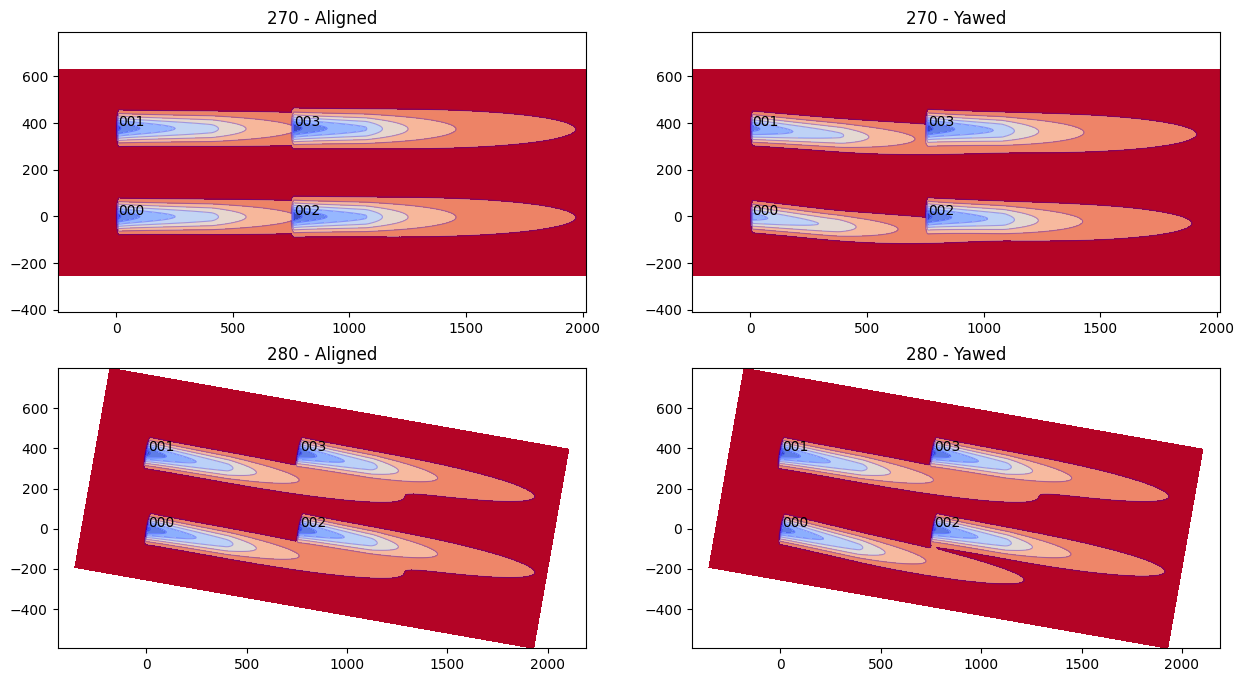

In [9]:
from floris.flow_visualization import visualize_cut_plane
from floris.layout_visualization import plot_turbine_labels

fig, axarr = plt.subplots(2, 2, figsize=(15,8))

# Plot the first wind condition
wd = wind_directions[0]
ws = wind_speeds[0]
ti = turbulence_intensities[0]

fmodel.reset_operation()
fmodel.set(wind_speeds=[ws], wind_directions=[wd], turbulence_intensities=[ti])
horizontal_plane = fmodel.calculate_horizontal_plane(height=90.0)
visualize_cut_plane(horizontal_plane, ax=axarr[0,0], title="270 - Aligned")
plot_turbine_labels(fmodel, axarr[0,0])

fmodel.set(yaw_angles=yaw_angles[0:1])
horizontal_plane = fmodel.calculate_horizontal_plane(height=90.0)
visualize_cut_plane(horizontal_plane, ax=axarr[0,1], title="270 - Yawed")
plot_turbine_labels(fmodel, axarr[0,1])

# Plot the second wind condition
wd = wind_directions[1]
ws = wind_speeds[1]
ti = turbulence_intensities[1]

fmodel.reset_operation()
fmodel.set(wind_speeds=[ws], wind_directions=[wd], turbulence_intensities=[ti])
horizontal_plane = fmodel.calculate_horizontal_plane(height=90.0)
visualize_cut_plane(horizontal_plane, ax=axarr[1,0], title="280 - Aligned")
plot_turbine_labels(fmodel, axarr[1,0])

fmodel.set(yaw_angles=yaw_angles[1:2])
horizontal_plane = fmodel.calculate_horizontal_plane(height=90.0)
visualize_cut_plane(horizontal_plane, ax=axarr[1,1], title="280 - Yawed")
plot_turbine_labels(fmodel, axarr[1,1])

plt.show()

We can also plot the streamwise inflow velocities on the turbine rotor
grid points located on the rotor plane. The `plot_rotor_values` function
simply plots any data given as the first argument, so in this case
`fi.floris.flow_field.u` contains the yawed calculation from above.

In [10]:
# Set the FlorisModel as it was before visualizing the cut planes
fmodel.reset_operation()
fmodel.set(
    layout_x=x,
    layout_y=y,
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    turbulence_intensities=turbulence_intensities,
)
fmodel.run()

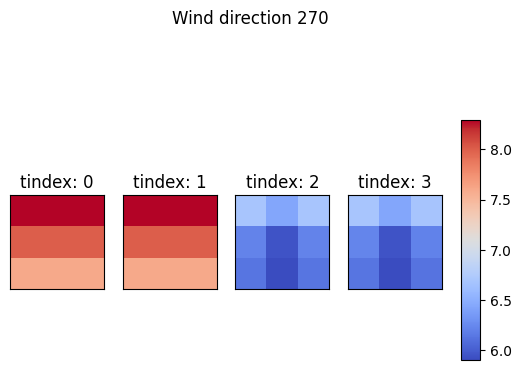

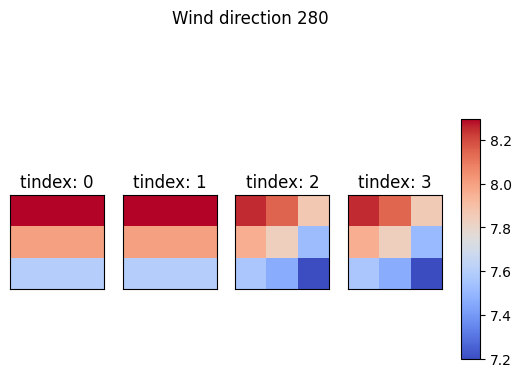

In [11]:
from floris.flow_visualization import plot_rotor_values

fig, _, _ , _ = plot_rotor_values(fmodel.core.flow_field.u, findex=0, n_rows=1, n_cols=4, return_fig_objects=True)
fig.suptitle("Wind direction 270")

fig, _, _ , _ = plot_rotor_values(fmodel.core.flow_field.u, findex=1, n_rows=1, n_cols=4, return_fig_objects=True)
fig.suptitle("Wind direction 280")

plt.show()

## On grid points

In FLORIS, grid points are the points in space where the wind conditions are calculated.
In a typical simulation, these are all located on a regular grid on each turbine rotor.

The parameter `turbine_grid_points` specifies the number of rows and columns which define the turbine grid.
In the example inputs, this value is 3 meaning there are 3 x 3 = 9 total grid points for each turbine.
Wake steering codes currently require greater values greater than 1 in order to compute gradients.
However, a single grid point (1 x 1) may be suitable for non wind farm control applications,
but retuning of some parameters might be required.

We can visualize the locations of the grid points in the current example using `matplotlib.pyplot`.

shape of xs: (2, 4, 3, 3)
  2 wd x 2 ws x 4 turbines x 3 x 3 grid points


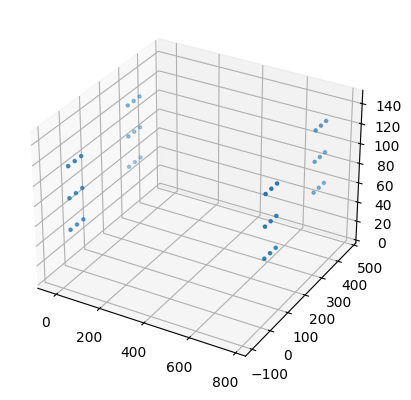

In [12]:
# Get the grid points
xs = fmodel.core.grid.x_sorted
ys = fmodel.core.grid.y_sorted
zs = fmodel.core.grid.z_sorted

# Consider the shape
print(f"shape of xs: {xs.shape}")
print("  2 wd x 2 ws x 4 turbines x 3 x 3 grid points")

# Lets plot just one wd/ws conditions
xs = xs[1, :, :, :]
ys = ys[1, :, :, :]
zs = zs[1, :, :, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs, ys, zs, marker=".")
ax.set_zlim([0, 150])

plt.show()

## Basic use case: calculating AEP

FLORIS leverages vectorized operations on the CPU to reduce the computation
time for bulk calculations, and this is especially meaningful for calculating
annual energy production (AEP) on a wind rose.
Here, we demonstrate a simple AEP calculation for a 25-turbine farm
using several different modeling options. We make the assumption
that every wind speed and direction is equally likely. We also
report the time required for the computation using the Python
`time.perf_counter()` function.

In [13]:
import time
from typing import Tuple

# Using Numpy.meshgrid, we can combine 1D arrays of wind speeds and wind directions to produce
# combinations of both. Though the input arrays are not the same size, the resulting arrays
# will be the same size.
wind_directions, wind_speeds = np.meshgrid(
    np.arange(0.0, 360.0, 5),   # wind directions 0 to 360 degrees (exclusive) in 5 degree increments
    np.arange(8.0, 12.0, 0.2),  # wind speeds from 8 to 12 m/s in 0.2 m/s increments
    indexing="ij"
)
# meshgrid returns arrays with shape (len(wind_speeds), len(wind_directions)), so we "flatten" them
wind_directions = wind_directions.flatten()
wind_speeds = wind_speeds.flatten()
turbulence_intensities = 0.1 * np.ones_like(wind_speeds)

n_findex = len(wind_directions)
print(f"Calculating AEP for {n_findex} wind direction and speed combinations...")

# Set up a square 25 turbine layout
N = 5  # Number of turbines per row and per column
D = 126.0

# Create the turbine locations using the same method as above
x, y = np.meshgrid(
    7.0 * D * np.arange(0, N, 1),
    7.0 * D * np.arange(0, N, 1),
)
x = x.flatten()
y = y.flatten()
print(f"Number of turbines = {len(x)}")

# Define several models
fmodel_jensen = FlorisModel("jensen.yaml")
fmodel_gch = FlorisModel("gch.yaml")
fmodel_cc = FlorisModel("cc.yaml")

# Assign the layouts, wind speeds and directions
fmodel_jensen.set(
    layout_x=x,
    layout_y=y,
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    turbulence_intensities=turbulence_intensities
)
fmodel_gch.set(
    layout_x=x,
    layout_y=y,
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    turbulence_intensities=turbulence_intensities,
)
fmodel_cc.set(
    layout_x=x,
    layout_y=y,
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    turbulence_intensities=turbulence_intensities,
)

def time_model_calculation(model_fmodel: FlorisModel) -> Tuple[float, float]:
    """
    This function performs the wake calculation for a given
    FlorisModel object and computes the AEP while
    tracking the amount of wall-time required for both steps.

    Args:
        model_fmodel (FlorisModel): _description_
        float (_type_): _description_

    Returns:
        tuple(float, float):
            0: AEP
            1: Wall-time for the computation
    """
    start = time.perf_counter()
    model_fmodel.run()
    aep = model_fmodel.get_farm_power().sum() / n_findex  / 1E9 * 365 * 24
    end = time.perf_counter()
    return aep, end - start

jensen_aep, jensen_compute_time = time_model_calculation(fmodel_jensen)
gch_aep, gch_compute_time = time_model_calculation(fmodel_gch)
cc_aep, cc_compute_time = time_model_calculation(fmodel_cc)

print('Model    AEP (GWh)  Compute Time (s)')
print('{:8s} {:<10.3f} {:<6.3f}'.format("Jensen", jensen_aep, jensen_compute_time))
print('{:8s} {:<10.3f} {:<6.3f}'.format("GCH", gch_aep, gch_compute_time))
print('{:8s} {:<10.3f} {:<6.3f}'.format("CC", cc_aep, cc_compute_time))

Calculating AEP for 1440 wind direction and speed combinations...
Number of turbines = 25
Model    AEP (GWh)  Compute Time (s)
Jensen   661.838    0.438 
GCH      683.869    1.489 
CC       661.315    3.243 


## Basic use case: wake steering design

FLORIS includes a set of optimization routines for the design of wake steering controllers.
`SerialRefine` is a new method for quickly identifying optimum yaw angles.

In [14]:
# Demonstrate on 7-turbine single row farm
x = np.linspace(0, 6*7*D, 7)
y = np.zeros_like(x)
wind_directions = np.arange(0.0, 360.0, 2.0)
wind_speeds = 8.0 * np.ones_like(wind_directions)
turbulence_intensities = 0.1 * np.ones_like(wind_directions)
fmodel_gch.set(
    layout_x=x,
    layout_y=y,
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    turbulence_intensities=turbulence_intensities,
)

In [15]:
from floris.optimization.yaw_optimization.yaw_optimizer_sr import YawOptimizationSR

# Define the SerialRefine optimization
yaw_opt = YawOptimizationSR(
    fmodel=fmodel_gch,
    minimum_yaw_angle=0.0,  # Allowable yaw angles lower bound
    maximum_yaw_angle=25.0,  # Allowable yaw angles upper bound
    Ny_passes=[5, 4],
    exclude_downstream_turbines=True,
)

In [16]:
start = time.perf_counter()

## Calculate the optimum yaw angles for 25 turbines and 72 wind directions
df_opt = yaw_opt.optimize()

end = time.perf_counter()

walltime = end - start
print(f"Optimization wall time: {walltime:.3f} s")


[Serial Refine] Processing pass=0, turbine_depth=0 (0.0%)
[Serial Refine] Processing pass=0, turbine_depth=1 (7.1%)
[Serial Refine] Processing pass=0, turbine_depth=2 (14.3%)
[Serial Refine] Processing pass=0, turbine_depth=3 (21.4%)
[Serial Refine] Processing pass=0, turbine_depth=4 (28.6%)
[Serial Refine] Processing pass=0, turbine_depth=5 (35.7%)
[Serial Refine] Processing pass=0, turbine_depth=6 (42.9%)
[Serial Refine] Processing pass=1, turbine_depth=0 (50.0%)
[Serial Refine] Processing pass=1, turbine_depth=1 (57.1%)
[Serial Refine] Processing pass=1, turbine_depth=2 (64.3%)
[Serial Refine] Processing pass=1, turbine_depth=3 (71.4%)
[Serial Refine] Processing pass=1, turbine_depth=4 (78.6%)
[Serial Refine] Processing pass=1, turbine_depth=5 (85.7%)
[Serial Refine] Processing pass=1, turbine_depth=6 (92.9%)
Optimization wall time: 3.771 s


In the results, T0 is the upstream turbine when wind direction is 270, while T6 is upstream at 90 deg

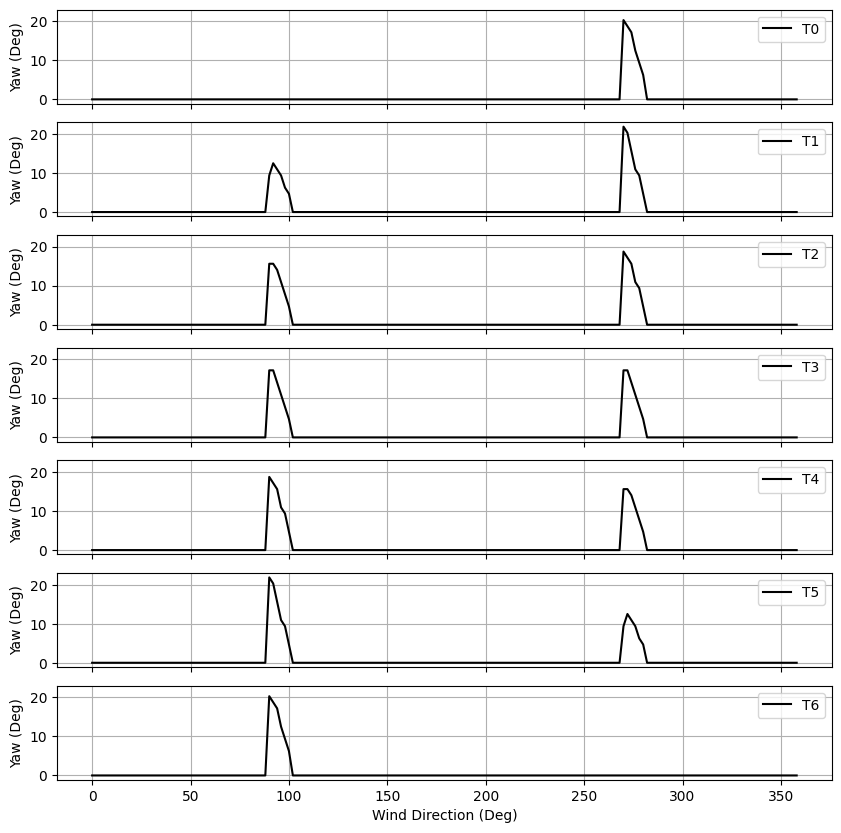

In [17]:
# Show the results
yaw_angles_opt = np.vstack(df_opt["yaw_angles_opt"])
fig, axarr = plt.subplots(len(x), 1, sharex=True, sharey=True, figsize=(10, 10))
for i in range(len(x)):
    axarr[i].plot(wind_directions, yaw_angles_opt[:, i], 'k-', label='T%d' % i)
    axarr[i].set_ylabel('Yaw (Deg)')
    axarr[i].legend()
    axarr[i].grid(True)
axarr[-1].set_xlabel('Wind Direction (Deg)')

plt.show()